## Exploration 1 : Can one have usage maps that are a bit more informative than population maps?

Google Analytics traffic maps look for the market region concerned by the website or the app it tracks like pretty much population maps. Of course one can spot out a few variations, but it's often hard to visualize how different the traffic distribution is from the population distribution.

Let's do it!

### Tools used
* [pandas](http://pandas.pydata.org/) and its [Google Analytics connector](http://pandas.pydata.org/pandas-docs/version/0.15.2/remote_data.html#remote-data-ga) to fetch and wrangle the data,
* (matplotlib)[http://matplotlib.org/] to simply visualize it.

### Data sources
* The traffic data comes from the Google Analytics property of [liip.ch](http://www.liip.ch).
* Aside from traffic data, we also need population data. The file 'ptot-cities.csv' provides it for Switzerland, on a locality basis. Data courtesy of [microgis.ch]

In [15]:
import numpy as np

import pandas as pd
import pandas.io.ga as ga

import matplotlib.pylab as pylab
import matplotlib.pyplot as plt
pd.options.display.mpl_style = 'default'
%matplotlib inline

In [16]:
import sys
print ("PYTHON ", sys.version)
print ("NUMPY ", np.__version__)
print ("PANDAS ", pd.__version__)

PYTHON  3.4.3 |Anaconda 2.4.0 (x86_64)| (default, Oct 20 2015, 14:27:51) 
[GCC 4.2.1 (Apple Inc. build 5577)]
NUMPY  1.10.1
PANDAS  0.17.0


### Fetching data

In [17]:
# load swiss cities population data
df2 = pd.io.parsers.read_csv(
    'ptot-cities.csv',
    sep = ',',
    encoding = 'iso-8859-1',
)

## munge it
#df2['city'] = df2['city'].apply(lambda (s): unidecode(s))
df2 = df2.sort_values(by = 'population')

# let's check it out
df2.tail()

,city,population
202,Bern,127515
1875,Lausanne,130421
970,Basel,165566
2274,Geneva,189033
168,Zürich,380777


In [18]:
# get the traffic and geo positions data from google analytics
df1 = ga.read_ga(
    property_id = "UA-424540-7",
    profile_id  = "66369850",
    metrics     = "users",
    dimensions  = ['city','latitude', 'longitude'],
    start_date  = "2014-01-01",
    filters     = ["country==Switzerland"],
    index_col   = 0,
)

# munge it
df1 = df1.reset_index().sort_values(by = "users")

# have a look at it
df1.tail()

,city,latitude,longitude,users
172,Fribourg,46.8017,7.1456,2835
183,Geneva,46.1984,6.1423,3271
274,Lausanne,46.5200,6.6336,5131
55,Bern,46.9479,7.4446,5466
581,Zurich,47.3686,8.5392,21643


In [19]:
# merge the two dataframes, matching on city names
df = pd.merge(df1, df2, on = 'city', how = 'left')

# munge it
df = df.dropna()

# compute the density ratio = "users" / population
df['density'] = df["users"] / df['population']
df = df.sort_values(by = 'density')

# let's have a look at it
df.tail()

,city,latitude,longitude,users,population,density
560,Ecublens,46.5255,6.5628,360,11427,0.031504
577,Saint Gallen,47.4179,9.3644,2644,74111,0.035676
580,Lausanne,46.5200,6.6336,5131,130421,0.039342
581,Bern,46.9479,7.4446,5466,127515,0.042866
578,Fribourg,46.8017,7.1456,2835,36633,0.077389


/Users/benoitpointet/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


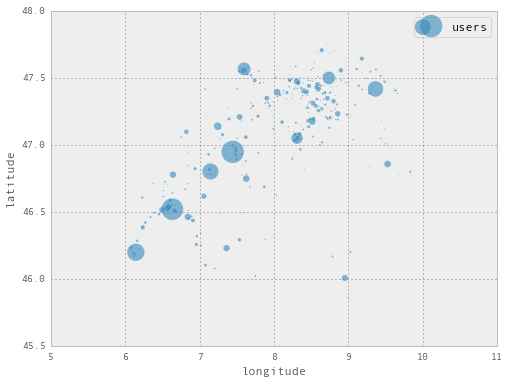

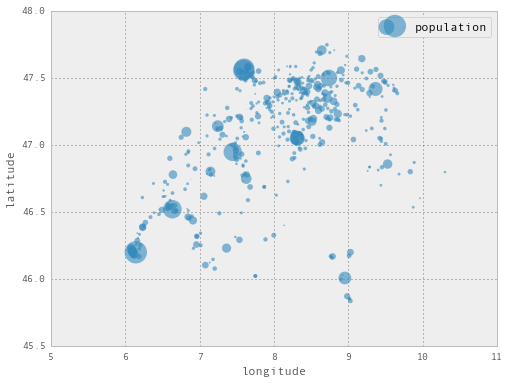

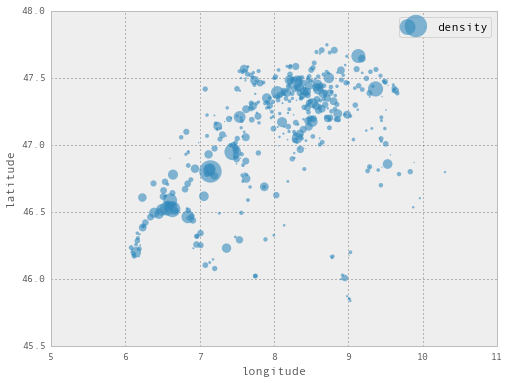

In [20]:
# generate a basic swiss map, 
for dim in ["users", 'population', 'density']:
    df.plot(
        kind = 'scatter', 
        x = 'longitude', 
        y = 'latitude', 
        alpha = 0.6, 
        s = df[dim]/df[dim].max()*500, 
        linewidths = 0, 
        figsize = (8,6),
        label = dim
    )

### Facts

The users and population maps, look roughly the same, with the main cities being visually poping out, yet differently on both maps.

The last "density" map shows a different picture: the peripheral locations gain importance, and big cities like Lausanne, 
Zurich melt with their urban region. 

### Interpretations

The interest for Liip services spreads in the whole metro area around each of its offices.

## Exploration 2 : how does content interest vary throughout the country?

In [21]:
# let's functionalize the above data wrangling code
def density(path = False, browser = False, dayOfWeek = False, hour = False):
    
    filters = "country==Switzerland"
    if path:
        filters += ";ga:pagePath=~" + path
    if browser:
         filters += ";ga:browser=~" + browser
    if dayOfWeek:
         filters += ";ga:dayOfWeek=~" + dayOfWeek        
    if hour:
         filters += ";ga:hour=~" + hour        
            
            
    the_metric = 'sessions'
    # the_metric = 'users'
    
    df1 = ga.read_ga(
        property_id = "UA-424540-7",
        profile_id  = "66369850",
        metrics     = the_metric,
        dimensions  = ['city','latitude', 'longitude'],
        start_date  = "2014-01-01",
        end_date    = "2014-12-31",
        filters     = [filters],
        index_col   = 0,
    )

    # munge it
    df1 = df1.reset_index()

    # merge the two dataframes, matching on city names
    df = pd.merge(df1, df2, on = u'city', how = 'left')

    # munge and extend it
    df = df.dropna()
    df['density'] = df[the_metric] / df['population']
    df["density_norm"] = df["density"] / df["density"].max()
#    df["density_norm"] = df["density"] * 500
    
    return df

# and commoditize the multi-layered scatter-plotting functions

def new_plot():
    ax = plt.figure().add_subplot(111)
    plot_offices(ax)
    return ax

def plot_layer(ax, df, label = '', alpha = 1, color = "Grey"):
    df.plot(
        kind = 'scatter',
        x = 'longitude', 
        y = 'latitude', 
        s = df['density_norm']*500,
        linewidths = 0, 
        figsize = (12,9),
        alpha = alpha,
        color = color,
        label = label,
        ax = ax,
    )

# also add the offices as landmarks
def plot_offices(ax):
    offices = {
        'city' : ['Fribourg', 'Saint Gallen', 'Lausanne', 'Zurich'],
        'latitude' : [46.8017, 47.4179, 46.5200, 47.3686],
        'longitude' : [7.1456, 9.3644, 6.6336, 8.5392],
    }
    dfo = pd.DataFrame(offices)
    dfo.plot(
        kind = 'scatter',
        x = 'longitude',
        y = 'latitude',
        s = 20,
        alpha = 1,
        color = 'black',
        label = 'offices',
        ax = ax,
        zorder = 10000,
    )


In [22]:
# compute jobs and products traffic density
jobs_density = density('jobs')
products_density = density('products')

/Users/benoitpointet/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


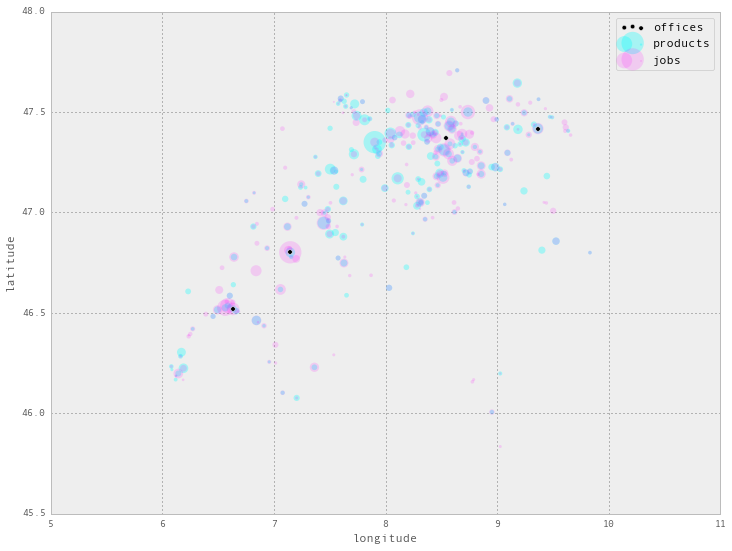

In [23]:
ax = new_plot()
plot_layer(ax, products_density, "products", 0.3, "Cyan")
plot_layer(ax, jobs_density, "jobs", 0.15, "Magenta")

### Facts

* Cities centers around Liip offices in Lausanne and Fribourg are noticeably more interested in jobs than in products.
* Peripheral towns seem more interested in products than jobs.
* Regions far from the company's offices like Basel and Geneva region are more interested in products than jobs.

### Interpretations

* Most of those who are interested in Liip jobs live close to a Liip office.
* Some regions are aware of the offering of the agency even without an office in it.

# Exploration 3: How do visits differ throughout the week?

/Users/benoitpointet/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


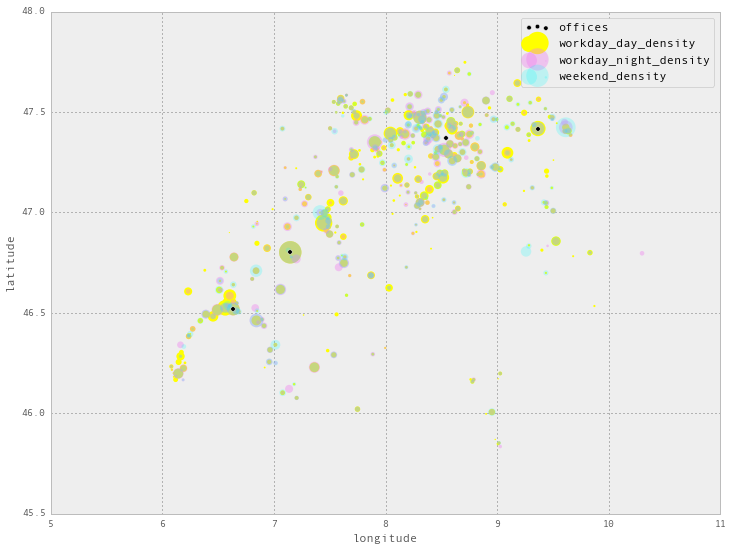

In [24]:
workday_day_density = density (
    dayOfWeek = '1|2|3|4|5', 
    hour = '07|08|09|10|11|12|13|14|15|16|17|18'
)

workday_night_density = density (
    dayOfWeek = '1|2|3|4|5', 
    hour = '19|20|21|22|23|00|01|02|03|04|05|06'
)

weekend_density = density (
    dayOfWeek = '6|0'
)

ax = new_plot()
plot_layer(ax, workday_day_density, "workday_day_density", 1, "Yellow")
plot_layer(ax, workday_night_density, "workday_night_density", 0.4, "Violet")
plot_layer(ax, weekend_density, "weekend_density", 0.2, "Cyan")

### Interpretations
* Remote regions like the Chablais are more likely to show an interest off-work for the company.